In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import OrderedDict
import xgboost as xgb
import pickle
import rebound
import matplotlib.pyplot as plt
%matplotlib inline  


#if a collision occurs, end the simulation
def collision(reb_sim, col):
    reb_sim.contents._status = 5 # causes simulation to stop running and have flag for whether sim stopped due to collision
    return 0

#To generate your own features that can be passed to the model to generate predictions 
#from your simulations, you need to use/copy the function "generate_features" from here - 
#https://github.com/Naireen/MLstability/blob/orbelements/generate_features/generatefeaturesscriptNoLyaMoreFeats.py - 
#which accepts a rebound simulation (i.e. so make your simulation in an identical manner 
#that you would as if you were going to run on ACI-b, but then pass to this function instead). 

def generate_features(sim):
    
    #Lastly, in the generate_features function there's a few constants you have to hardcode: 
    maxorbs = 10000 #length of the integration. The model was trained with data integrated for maxorbs orbits for the inner most planet.
    Nout = 100 #how many data points to output. This means you measure the eccentricities, distances, etc every 100 orbits. 
    window = 10 #This is to look at the first n points and determine features from just this small subset of the data. You're essentially looking at its initial short term behavior. 
    
    
    t0 = time.time()
    ps = sim.particles
    

    P0 = ps[1].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate
    
    sim.collision_resolve = collision

    #kicksize=1.e-11
    #sim2.particles[2].x += kicksize
    
    E0 = sim.calculate_energy()
    times = np.linspace(0,tmax,Nout)
    
    a = np.zeros((sim.N,Nout))
    e = np.zeros((sim.N,Nout))
    inc = np.zeros((sim.N,Nout))
    
    beta12 = np.zeros( Nout)
    beta23 = np.zeros(Nout)

    Rhill12 = ps[1].a*((ps[1].m+ps[2].m)/3.)**(1./3.)
    Rhill23 = ps[2].a*((ps[2].m+ps[3].m)/3.)**(1./3.)
    
    eHill = [0, Rhill12/ps[1].a, max(Rhill12, Rhill23)/ps[2].a, Rhill23/ps[3].a]
    daOvera = [0, (ps[2].a-ps[1].a)/ps[1].a, min(ps[3].a-ps[2].a, ps[2].a-ps[1].a)/ps[2].a, (ps[3].a-ps[2].a)/ps[3].a]
    
    for i, t in enumerate(times):
        for j in [1,2,3]:
            a[j,i] = ps[j].a
            e[j,i] = ps[j].e
            inc[j,i] = ps[j].inc

        #need to update rhills?
        Rhill12 = ps[1].a*((ps[1].m+ps[2].m)/3.)**(1./3.)
        Rhill23 = ps[2].a*((ps[2].m+ps[3].m)/3.)**(1./3.)
        
        beta12[i] = (ps[2].a - ps[1].a)/Rhill12
        beta23[i] = (ps[3].a - ps[2].a)/Rhill23   
        sim.integrate(t)
    
    features = OrderedDict()
    features['t_final_short'] = sim.t/P0
    Ef = sim.calculate_energy()
    features['Rel_Eerr_short'] = abs((Ef-E0)/E0)




    for string, feature in [("beta12", beta12), ("beta23", beta23)]:
        mean = feature.mean()
        std = feature.std()
        features["avg_"+string] = mean
        features["std_"+string] = std
        features["min_"+string] = min(feature)
        features["max_"+string] = max(feature)

    
    for j in [1,2,3]:
        for string, feature in [('a', a), ('e', e), ('inc', inc)]:
            mean = feature[j].mean()
            std = feature[j].std()
            features['avg_'+string+str(j)] = mean
            features['std_'+string+str(j)] = std
            features['max_'+string+str(j)] = feature[j].max()
            features['min_'+string+str(j)] = feature[j].min()
            features['norm_std_'+string+str(j)] = std/mean
            features['norm_max_'+string+str(j)] = np.abs(feature[j] - mean).max()/mean
            sample = feature[j][:window]
            samplemean = sample.mean()
            features['norm_std_window'+str(window)+'_'+string+str(j)] = sample.std()/samplemean
            features['norm_max_window'+str(window)+'_'+string+str(j)] = np.abs(sample - samplemean).max()/samplemean

        for string, feature in [('eH', e), ('iH', inc)]:
            mean = feature[j].mean()
            std = feature[j].std()

            features['avg_'+string+str(j)] = mean/eHill[j]
            features['std_'+string+str(j)] = std/eHill[j]
            features['max_'+string+str(j)] = feature[j].max()/eHill[j]
            features['min_'+string+str(j)] = feature[j].min()/eHill[j]

        string, feature = ('ecross', e)
        features['avg_'+string+str(j)] = mean/daOvera[j]
        features['std_'+string+str(j)] = std/daOvera[j]
        features['max_'+string+str(j)] = feature[j].max()/daOvera[j]
        features['min_'+string+str(j)] = feature[j].min()/daOvera[j]

        xx = range(a[j].shape[0])
        yy = a[j]/a[j].mean()/features["t_final_short"]
        par = np.polyfit(xx, yy, 1, full=True)
        features['norm_a'+str(j)+'_slope'] = par[0][0]

    t = time.time()
    features['wall_time'] = t-t0
    return pd.Series(features, index=list(features.keys()))

#convert simulation archive to dataframe
def sa_2_features(sa):
    sim=sa[0]
    features_series=generate_features(sim)
    featurescolumns=list(features_series.index)
    featuresvalues=np.array(features_series)
    featuresvalues=featuresvalues.reshape(1,len(featuresvalues))
    features_df=pd.DataFrame(data=featuresvalues, columns=featurescolumns)
    return features_df

/storage/work/ajs725/conda/install/envs/stability/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
#Generating features

systembase = "Ari_Fake_10_0.1_r"
Np = 4

testlen=500
total=testlen*Np
tracker=0
for j in range(Np):
    system=systembase+str(j+1)
    for i in range(testlen):
        id_ = int(i)
        name = system+"_"+str(id_)
        if i==0:
            
            sa = rebound.SimulationArchive('output/%s/%s_SA.bin'%(system,name))
            features=sa_2_features(sa)
        
        else:
            
            sa = rebound.SimulationArchive('output/%s/%s_SA.bin'%(system,name))
            features2=sa_2_features(sa)
            features=pd.concat([features,features2], axis=0)
            
        tracker+=1
        if tracker%10==0:
            print("%3.2f%% complete"%(tracker/total*100))
    features.to_csv('%s_features.csv'%system)

/storage/work/ajs725/conda/install/envs/stability/lib/python3.5/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars
/storage/work/ajs725/conda/install/envs/stability/lib/python3.5/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars
/storage/work/ajs725/conda/install/envs/stability/lib/python3.5/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars
/storage/work/ajs725/conda/install/envs/stability/lib/python3.5/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars


0.50% complete
1.00% complete
1.50% complete
2.00% complete
2.50% complete
3.00% complete
3.50% complete
4.00% complete
4.50% complete
5.00% complete
5.50% complete
6.00% complete
6.50% complete
7.00% complete
7.50% complete
8.00% complete
8.50% complete
9.00% complete
9.50% complete
10.00% complete
10.50% complete
11.00% complete
11.50% complete
12.00% complete
12.50% complete
13.00% complete
13.50% complete
14.00% complete
14.50% complete
15.00% complete
15.50% complete
16.00% complete
16.50% complete
17.00% complete
17.50% complete
18.00% complete
18.50% complete
19.00% complete
19.50% complete
20.00% complete
20.50% complete
21.00% complete
21.50% complete
22.00% complete
22.50% complete
23.00% complete
23.50% complete
24.00% complete
24.50% complete
25.00% complete
25.50% complete
26.00% complete
26.50% complete
27.00% complete
27.50% complete
28.00% complete
28.50% complete
29.00% complete
29.50% complete
30.00% complete
30.50% complete
31.00% complete
31.50% complete
32.00% comp

In [2]:
feature_list = []
feature_list += ['avg_iH1', 'avg_iH2']
feature_list += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
feature_list += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
feature_list += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
feature_list += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
feature_list += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
feature_list += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
feature_list += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
feature_list += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23']

simulations that ended in collision
[  0  11  14  18  22  27  34  35  40  57  59  60  69  74  78  82  83  89
  91 107 117 118 119 124 130 131 132 136 137 139 147 157 160 167 180 185
 189 191 197 202 209 210 216 217 221 226 229 232 239 251 256 257 258 278
 284 285 289 293 298 301 305 306 307 308 312 319 328 332 333 337 341 344
 353 365 373 380 381 389 396 397 403 405 406 408 412 414 416 418 420 424
 426 428 430 434 441 443 450 451 461 465 468 471 472 476 481 486 487 488
 498]


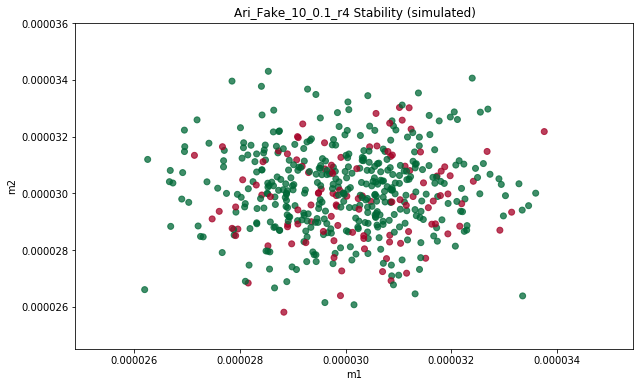

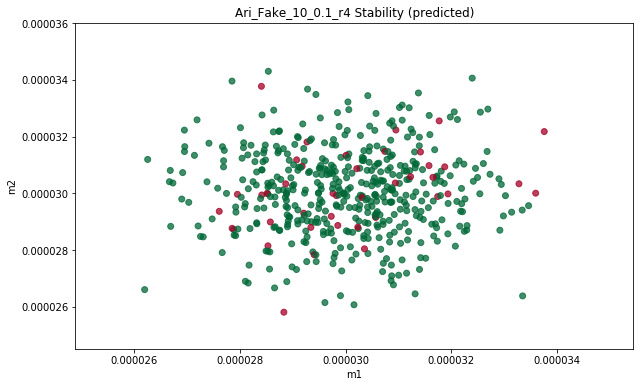

In [3]:
system="Ari_Fake_10_0.1_r4"
Np=3

dataset = pd.read_csv(system+'_features.csv')
X=xgb.DMatrix(dataset[feature_list])
model = pickle.load(open("final_Naireen2018.pkl", "rb"))
predictions = model.predict(X)
#print(predictions)

testlen=500
m1=np.zeros(testlen)
m2=np.zeros(testlen)
lensa=1000*np.ones(testlen)
for i in range(testlen):
    id_ = int(i)
    name = system+"_"+str(id_)
    sa = rebound.SimulationArchive('output/%s/%s_SA.bin'%(system,name))
    sim0 = sa[0]
    m1[i]=sim0.particles[1].m
    m2[i]=sim0.particles[2].m
    lensa[i]=len(sa)

collide=np.unique(np.where(lensa<1000))
print("simulations that ended in collision")
print(collide)
unstable=lensa<1000
unstablepred=predictions<0.5

color = 1-1*unstable
colorpred = 1-1*unstablepred

plt.figure(figsize=(10,6))
plt.scatter(m1,m2,c=color,alpha=0.75,cmap="RdYlGn")
plt.xlabel("m1")
plt.ylabel("m2")
plt.title("%s Stability (simulated)"%(system))
plt.xlim(0.95*min(m1),1.05*max(m1))
plt.ylim(0.95*min(m2),1.05*max(m2))
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(m1,m2,c=colorpred,alpha=0.75,cmap="RdYlGn")
plt.xlabel("m1")
plt.ylabel("m2")
plt.title("%s Stability (predicted)"%(system))
plt.xlim(0.95*min(m1),1.05*max(m1))
plt.ylim(0.95*min(m2),1.05*max(m2))
plt.show()

/storage/work/ajs725/conda/install/envs/stability/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


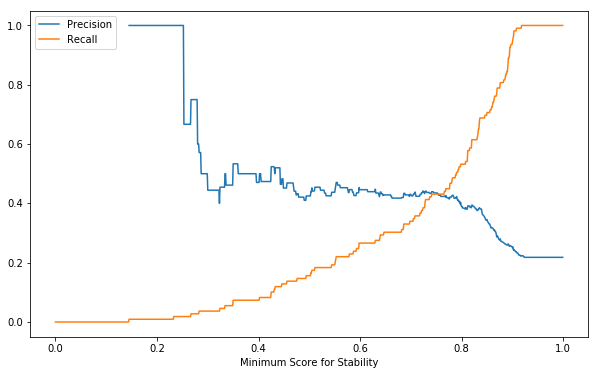

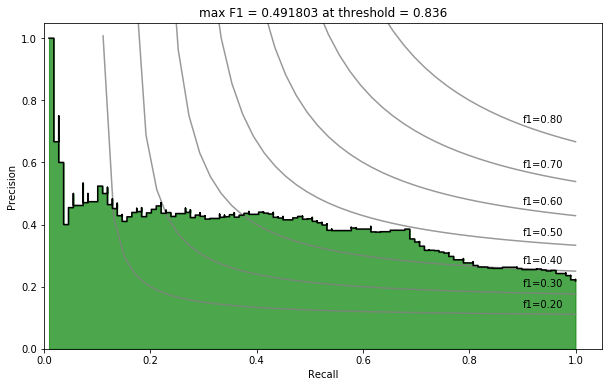

In [4]:
fine=1000
precision=np.zeros(fine)
recall=np.zeros(fine)
x=np.arange(fine)/fine
f1=np.zeros(fine)
for i in range(fine):
    unstablepred=predictions<x[i]
    tp = unstablepred & unstable
    precision[i] = sum(tp)/sum(unstablepred)
    recall[i] = sum(tp)/sum(unstable)
    f1[i]=2*(precision[i]*recall[i])/(precision[i]+recall[i])

maxf1 = max(f1[~np.isnan(f1)])
maxthreshold= x[np.where(f1==maxf1)]
plt.figure(figsize=(10,6))
line1,=plt.plot(x,precision)
line2,=plt.plot(x,recall)
plt.xlabel("Minimum Score for Stability")
#plt.ylabel("m2")
#plt.title("%s Stability (predicted)"%(system))
plt.legend([line1, line2], ["Precision", "Recall"])
plt.show()


plt.figure(figsize=(10,6))

f_scores = np.linspace(0.2, 0.8, num=7)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='grey', alpha=0.8)
    plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    
plt.step(recall,precision, color='black', where='post')
plt.fill_between(recall,precision, step='post', alpha=0.7,color='g')
#plt.plot(precision,recall)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.title("max F1 = %f at threshold = %1.3f"%(maxf1,maxthreshold))
#plt.legend([line1, line2], ["Precision", "Recall"])
plt.show()

/storage/work/ajs725/conda/install/envs/stability/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


0.71961102107
0.782


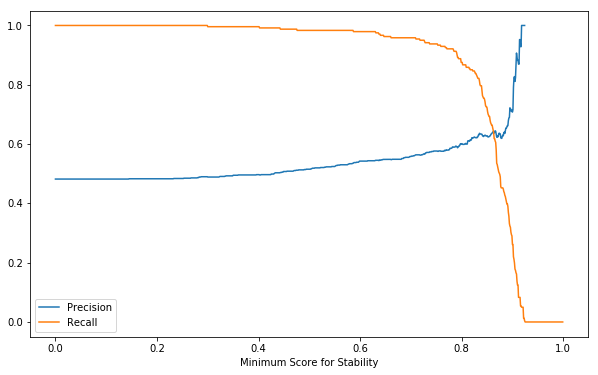

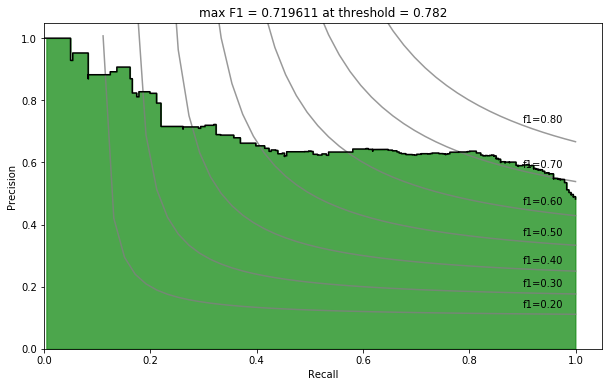

In [11]:
fine=1000
precision=np.zeros(fine)
recall=np.zeros(fine)
x=np.arange(fine)/fine
f1=np.zeros(fine)
for i in range(fine):
    stablepred=predictions>x[i]
    tp = stablepred & ~unstable
    precision[i] = sum(tp)/sum(stablepred)
    recall[i] = sum(tp)/sum(~unstable)
    f1[i]=2*(precision[i]*recall[i])/(precision[i]+recall[i])

maxf1 = max(f1[~np.isnan(f1)])
maxthreshold= x[np.where(f1==maxf1)][0]
print(maxf1)
print(maxthreshold)
plt.figure(figsize=(10,6))
line1,=plt.plot(x,precision)
line2,=plt.plot(x,recall)
plt.xlabel("Minimum Score for Stability")
#plt.ylabel("m2")
#plt.title("%s Stability (predicted)"%(system))
plt.legend([line1, line2], ["Precision", "Recall"])
plt.show()


plt.figure(figsize=(10,6))

f_scores = np.linspace(0.2, 0.8, num=7)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='grey', alpha=0.8)
    plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    
plt.step(recall,precision, color='black', where='post')
plt.fill_between(recall,precision, step='post', alpha=0.7,color='g')
#plt.plot(precision,recall)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.title("max F1 = %f at threshold = %1.3f"%(maxf1,maxthreshold))
#plt.legend([line1, line2], ["Precision", "Recall"])
plt.show()

simulations that ended in collision
[  0   7   8  11  13  14  16  17  18  20  22  24  27  28  30  33  34  35
  36  37  40  43  45  46  47  48  49  53  56  57  59  60  62  66  68  69
  74  75  76  78  79  82  83  84  87  89  90  91  92  96  97 101 102 104
 105 107 108 109 111 114 115 117 118 121 127 128 129 131 132 134 135 136
 137 138 139 143 144 145 148 150 151 152 154 155 157 159 160 163 164 166
 167 169 172 174 180 181 182 183 184 185 186 187 188 189 191 192 193 194
 195 197 199 202 206 207 209 210 211 216 217 221 223 226 227 229 230 232
 236 237 243 244 246 248 249 250 251 252 253 257 258 259 261 266 271 273
 274 275 278 282 284 285 286 287 289 290 291 292 293 294 296 297 300 301
 303 307 308 311 312 313 319 320 323 327 328 329 332 334 339 341 342 344
 346 348 350 353 356 357 358 361 365 369 370 373 378 379 381 386 389 392
 394 396 397 398 400 403 404 405 408 411 412 414 416 420 424 426 427 428
 430 432 433 434 435 437 439 441 443 444 446 448 449 450 451 452 454 455
 460 461 463 46

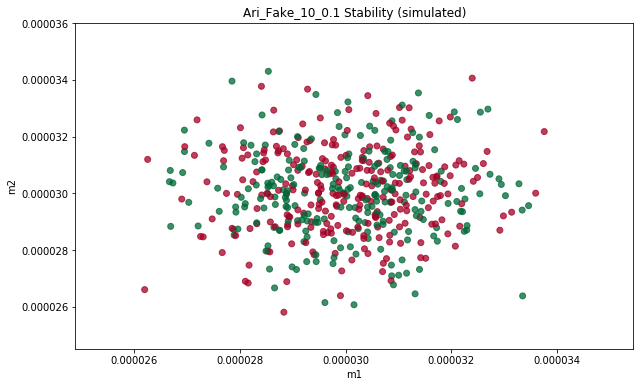

In [5]:
system="Ari_Fake_10_0.1"
Np=4

testlen=500
m1=np.zeros(testlen)
m2=np.zeros(testlen)
lensa=1000*np.ones(testlen)
for i in range(testlen):
    id_ = int(i)
    name = system+"_"+str(id_)

    sa = rebound.SimulationArchive('output/%s/%s_SA.bin'%(system,name))
    sim0 = sa[0]
    m1[i]=sim0.particles[1].m
    m2[i]=sim0.particles[2].m
    lensa[i]=len(sa)

collide=np.unique(np.where(lensa<1000))
print("simulations that ended in collision")
print(collide)
unstable=lensa<1000

color = 1-1*unstable
#colorpred = 1-1*unstablepred

plt.figure(figsize=(10,6))
plt.scatter(m1,m2,c=color,alpha=0.75,cmap="RdYlGn")
plt.xlabel("m1")
plt.ylabel("m2")
plt.title("%s Stability (simulated)"%(system))
plt.xlim(0.95*min(m1),1.05*max(m1))
plt.ylim(0.95*min(m2),1.05*max(m2))
plt.show()

#plt.scatter(h2,k2,c=colorpred,alpha=0.75,cmap="RdYlGn")
#plt.xlabel("h2")
#plt.ylabel("k2")
#plt.title("%s Stability (predicted)"%(system))
#plt.show()

In [ ]:
############################### NO LONGER USED

system="Ari_Fake_10_0.1_r1"
Np=3

dataset = pd.read_csv(system+'_features.csv')
X=xgb.DMatrix(dataset[feature_list])
model = pickle.load(open("final_Naireen2018.pkl", "rb"))
predictions = model.predict(X)
#print(predictions)

testlen=500
#sma=np.zeros((Np,testlen))
ecc=np.zeros((Np,testlen))
w=np.zeros((Np,testlen))
lensa=1000*np.ones(testlen)
for i in range(testlen):
    #if not (i==169 and system=="Ari_Fake_10_0.1_r2"):
    for j in range(Np):
        id_ = int(i)
        name = system+"_"+str(id_)
    
        sa = rebound.SimulationArchive('output/%s/%s_SA.bin'%(system,name))
        sim0 = sa[0]
        w[j,i]=sim0.calculate_orbits()[j].omega
        #sim = sa[-1]    
        ecc[j,i] = sim0.particles[j+1].e
        if j==0:
            lensa[i]=len(sa)
#sma=np.log10(np.abs(sma))

eject=np.unique(np.where((ecc>1) | (ecc<0))[1])
print("simulations that ended in ejection")
print(eject)
collide=np.unique(np.where((lensa<1000) & ((ecc<=1) & (ecc>=0))[1]))
print("simulations that ended in collision")
print(collide)
unstable=(((ecc>1) | (ecc<0))[1]) | (lensa<1000)
unstablepred=predictions<0.5

h2 = ecc[1,:]*np.sin(w[1,:])
k2 = ecc[1,:]*np.cos(w[1,:])
color = 1-1*unstable
colorpred = 1-1*unstablepred

plt.scatter(h2,k2,c=color,alpha=0.75,cmap="RdYlGn")
plt.xlabel("h2")
plt.ylabel("k2")
plt.title("%s Stability (simulated)"%(system))
plt.show()

plt.scatter(h2,k2,c=colorpred,alpha=0.75,cmap="RdYlGn")
plt.xlabel("h2")
plt.ylabel("k2")
plt.title("%s Stability (predicted)"%(system))
plt.show()